#### I. Referencias consultadas

# Numerical development to resolve Time-Dependent Schr√∂dinger equation through eigenvalue problem

## 1. Import modules with useful functions, parameters, and algorithms.

In [1]:
name_code = "03_Code";

In [2]:
include("../modules/module_schrodinger_equation_eigenproblem.jl"); # m√≥dulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie`


## 2. Setting grid properties

* Tipo de grilla
* Discretizaci√≥n espacial
* Dominio
* Condiciones de contorno

In [3]:
grid_type="simple_line";                            # tipo de grilla
ŒîxH=1.0/800.0;                                      # tama√±o del elento 1D

dom_1D=(-25.0,25.0);

par_1D=(path_models,grid_type*"_01",dom_1D,ŒîxH);    # (path,name,dom,MeshSize)

model_1D=make_model(grid_type,par_1D);              # creamos modelo

# condiciones de contorno
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[0.0,0.0];

Œ©_1D,dŒ©_1D,Œì_1D,dŒì_1D=measures(model_1D,3,dirichlet_tags_1D);
reffe_1D=reference_FEspaces(lagrangian,Float64,2);

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.0232617s, CPU 0.022526s)
Info    : 40001 nodes 40002 elements
Info    : Writing '../outputs/03_Code/models/simple_line_01.msh'...
Info    : Done writing '../outputs/03_Code/models/simple_line_01.msh'
Info    : Reading '../outputs/03_Code/models/simple_line_01.msh'...
Info    : 3 entities
Info    : 40001 nodes
Info    : 40002 elements
Info    : Done reading '../outputs/03_Code/models/simple_line_01.msh'


In [4]:
x,pts=space_coord(dom_1D,ŒîxH);

## 3. Eigenvalue method

La idea ac√° es resolver el problema de autovalores para el hamiltoniano $\hat {h}(x)$. Los espacios Test y Trial son reales, y no complejos, entonces buscamos obtener las partes reales e imaginarias de los autoestados por separado. 

El sistema se reduce a una ecuaci√≥n de Sturm-Liouville con par√°metros $p( x) ,q( x) ,r( x)$ defnidos como,

\begin{align}
    \begin{cases}
    p( x) =\frac{\hbar ^{2}}{2m}\\
    q(x) = V_\binom{electron}{nucleus}(x)\\
    r( x) =1
    \end{cases} \Rightarrow -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q( x)\begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)
    \end{pmatrix} =\lambda r( x)\begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)
    \end{pmatrix}
\end{align}

### 3.1. Resolvemos problema de autovalores para $\hat {h}_{x_0=0}(x)$

Definimos los espacios Test y Trial y construimos las formas bilineales que ser√°n de la forma:

\begin{align}
    \begin{array}{l}
    \begin{cases}
    a_{1}( u_{1} ,v_{1}) := \int _{\Omega }[ p( x)( \nabla v_{1} \cdotp \nabla u_{1}) +q( x)( v_{1} u_{1})] d\Omega \\
    a_{2}( u_{2} ,v_{2}) := \int _{\Omega }[ p( x)( \nabla v_{2} \cdotp \nabla u_{2}) +q( x)( v_{2} u_{2})] d\Omega 
    \end{cases}\\
    a(( u_{1} ,u_{2}) ,( v_{1} ,v_{2})) := a_{1}( u_{1} ,v_{1}) +a_{2}( u_{2} ,v_{2})\\
    \\
    \begin{cases}
    b_{1}( u_{1} ,v_{1}) := \int _{\Omega } r( x)( v_{1} u_{1}) d\Omega ; & b_{2}( u_{2} ,v_{2}) := \int _{\Omega } r( x)( v_{2} u_{2}) d\Omega 
    \end{cases}\\
    b(( u_{1} ,u_{2}) ,( v_{1} ,v_{2})) := b_{1}( u_{1} ,v_{1}) +b_{2}( u_{2} ,v_{2})
    \end{array}
\end{align}

In [5]:
V‚Çïre_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U‚Çïre_1D=TrialFESpace(V‚Çïre_1D,dirichlet_values_1D);
V‚Çïim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U‚Çïim_1D=TrialFESpace(V‚Çïim_1D,dirichlet_values_1D);
U‚Çï_1D = MultiFieldFESpace([U‚Çïre_1D, U‚Çïim_1D]);
V‚Çï_1D = MultiFieldFESpace([V‚Çïre_1D, V‚Çïim_1D]);

R=2.0;R‚ÇÅ=-5.0;R‚ÇÇ=5.0;Rc=1.5;Rf=1.5; # parameters

p‚Çï,q‚Çï,r‚Çï=eigenvalue_problem_functions((R,R‚ÇÅ,R‚ÇÇ,Rc,Rf);switch_potential = "Electron_Nuclear_Potential_1D")
a‚Çï_1D,b‚Çï_1D=bilineal_forms_ReImParts(p‚Çï,q‚Çï,r‚Çï,dŒ©_1D;switch_potential = "Electron_Nuclear_Potential_1D");

Set Electron-Nuclear potential with fixed R


Showing interaction potential plots

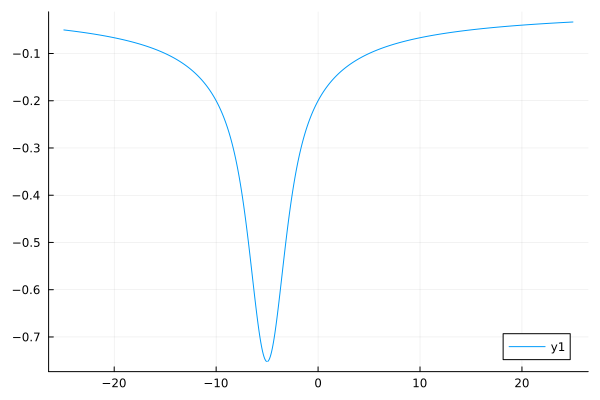

In [ ]:
plt1=plot();
plt2=plot!(plt1,x,Aprox_Coulomb_Potential.(x,R‚ÇÅ,Rc));

display(plt2)

Construimos el problema de autovalores, con par√°metros espec√≠ficos de resoluci√≥n

In [6]:
nev‚Çï=8; # debe ser m√∫ltiplo de 2
prob‚Çï_1D=EigenProblem(a‚Çï_1D,b‚Çï_1D,U‚Çï_1D,V‚Çï_1D;nev=nev‚Çï,tol=10^(-9),maxiter=300,explicittransform=:none);

Resolvermos el problema, para obtener autovalores y autoestados

In [7]:
œµ‚Çï_1D,œï‚Çï_1D=solve(prob‚Çï_1D);

Y ahora guardamos la parte real e imaginaria de los autoestados en un √∫nico autoestado complejo. Para ello deberemos definir nuevos espacios Test y Trial complejos.

Como los autoestados de la parte real e imaginaria asociadas a un mismo autoestado son degenerados, tendremos que saltear de a 2 (grado de degeneraci√≥n) los datos obtenidos para no duplicar resultados y quedarnos con s√≥lo aquellos resultados no triviales.

In [8]:
V‚Çïreim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U‚Çïreim_1D=TrialFESpace(V‚Çïreim_1D,dirichlet_values_1D);

œï‚Çïreim_1D=Vector{CellField}(undef,convert(Int32,prob‚Çï_1D.nev/2));

for i in 1:2:prob‚Çï_1D.nev
    f‚Çï_1D=interpolate_everywhere(œï‚Çï_1D[i],prob‚Çï_1D.trial);
    f‚Çïre_1D,f‚Çïim_1D=f‚Çï_1D;
    œï‚Çïreim_1D[convert(Int32,(i+1)/2)]=interpolate_everywhere(f‚Çïre_1D+im*f‚Çïim_1D,U‚Çïreim_1D);
end

Verificamos la normalizaci√≥n de los autoestados, para ello usando la funci√≥n anterior y deber√≠amos obtener resultados cercanos a la unidad

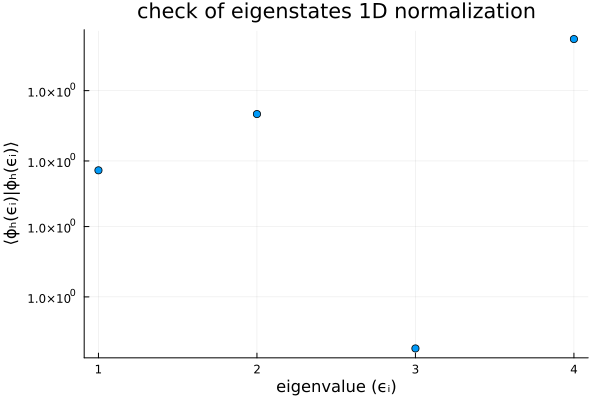

GKS: Possible loss of precision in routine SET_WINDOW


In [9]:
plotting=true
if plotting
    œï‚Çïreim_1D_norm=normalization_eigenstates_1D(œï‚Çïreim_1D,U‚Çïreim_1D,dŒ©_1D);
    plot‚ÇÅ=plot()
    plot‚ÇÅ=scatter!([i for i in 1:length(œï‚Çïreim_1D)],œï‚Çïreim_1D_norm,label="")
    plot‚ÇÅ=plot!(xlabel="eigenvalue (œµ·µ¢)",ylabel="‚ü®œï‚Çï(œµ·µ¢)|œï‚Çï(œµ·µ¢)‚ü©")
    plot‚ÇÅ=plot!(title="check of eigenstates 1D normalization")
    display(plot‚ÇÅ)
end

Ahora podemos graficar los diferentes autoestados

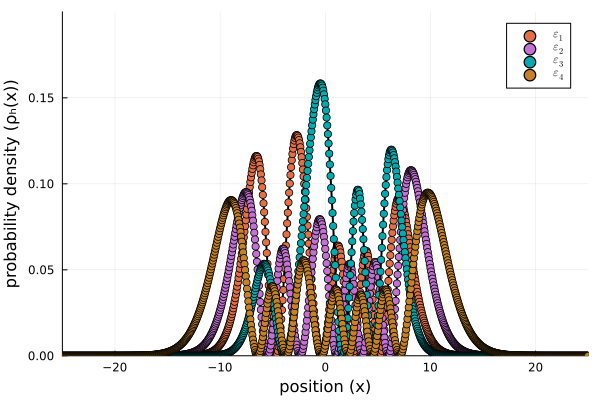

In [10]:
plotting=true
if plotting
    plot1=plot()
    œÅ‚Çïreim_1D=zeros(Float64,length(pts))
    for i in [1,2,3,4]
        œÅ‚Çïreim_1D=real(conj(œï‚Çïreim_1D[i].(pts)).*(œï‚Çïreim_1D[i].(pts)))
        plot1=plot!(x,œÅ‚Çïreim_1D,label="",lw=2,lc=:"black",ylim=(0,0.20),xlim=(-25,25))
        plot1=scatter!(x,œÅ‚Çïreim_1D,label="\$ \\epsilon_{$(i)}\$",lw=0.1,ylim=(0,0.20),xlim=(-25,25))
        plot1=plot!(xlabel="position (x)",ylabel="probability density (œÅ‚Çï(x))")
    end

    plot3=plot(plot1)
    display(plot3)
    # savefig(plot3,path_plots*"density_eigenstates_FWP_individual.pdf");
end

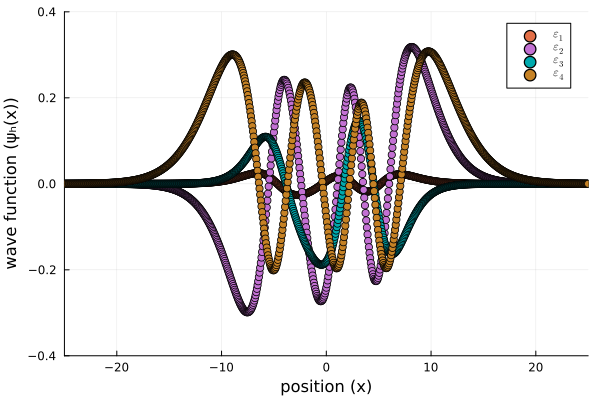

In [11]:
plotting=true
if plotting
    plot1=plot()
    œÅ‚Çïreim_1D=zeros(Float64,length(pts))
    for i in [1,2,3,4]
        œà‚Çïreim_1D=real(œï‚Çïreim_1D[i].(pts))
        plot1=plot!(x,œà‚Çïreim_1D,label="",lw=2,lc=:"black",ylim=(-0.4,0.4),xlim=(-25,25))
        plot1=scatter!(x,œà‚Çïreim_1D,label="\$ \\epsilon_{$(i)}\$",lw=0.1,ylim=(-0.4,0.4),xlim=(-25,25))
        plot1=plot!(xlabel="position (x)",ylabel="wave function (œà‚Çï(x))")
    end

    plot3=plot(plot1)
    display(plot3)
    # savefig(plot3,path_plots*"eigenstates_FWP_individual.pdf");
end

De la misma forma que para los autoestados debemos retener s√≥lo algunos resultados de los autovalores obtenidos, recordando la degeneraci√≥n de las partes real e imaginaria asociadas a un mismo autoestado.

In [12]:
œµ‚Çï‚ÇÅre_1D=œµ‚Çï_1D[1:2:end];    # vector de autovalores (SIN DEGENERACI√ìN)

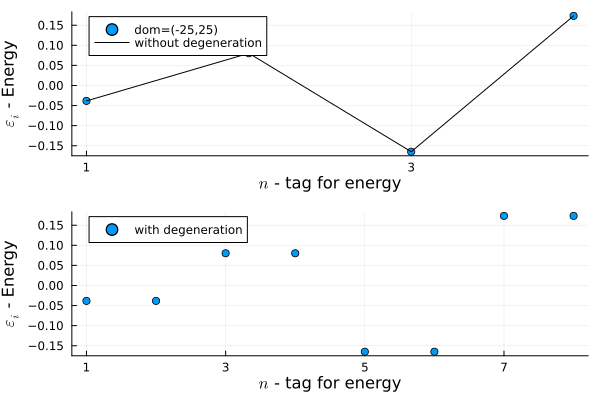

In [13]:
plotting=true

if plotting
    plot1=scatter([i for i in 1:nev‚Çï/2],œµ‚Çï‚ÇÅre_1D,label="dom=(-25,25)",xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nev‚Çï),lw=2)
    plot1=plot!([i for i in 1:nev‚Çï/2],œµ‚Çï‚ÇÅre_1D,label="without degeneration",lc=:"black",lw=1)
    plot1=plot!(legend=:topleft)

    plot2=scatter([i for i in 1:nev‚Çï],œµ‚Çï_1D,label="with degeneration")
    plot2=plot!(xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nev‚Çï),lw=2)
    plot2=plot!(legend=:topleft)

    plot3=plot(plot1,plot2,layout=(2,1))
    # savefig(plot3,path_plots*"eigenvalues_QHO_individual.pdf");
    display(plot3)
end

### 3.2. Calculus of differential Shannon entropy


Definition: The differential entropy $h(X)$ of a continuous variable X with density f(x) is defined as

\begin{align}
    h(X)=-\int_{S}f(x)log\left[ f(x) \right]dx
\end{align}

where $S$ is the support set of the random variable.
As in the discrete case, the differential entropy depends only on the probability density of the random variable, and therefore the differential entropy is sometimes written as $h(f)$ rather than $h(X)$.

Ref.: Cover, T.M., 1999. Elements of information theory. John Wiley & Sons.

In [14]:
S=TimeIndependet_Diff_Shannon_Entropy_1D(œï‚Çïreim_1D,U‚Çïreim_1D,dŒ©_1D)

4-element Vector{Float64}:
 0.013293194499690957
 0.015953689462457354
 0.010986784370153274
 0.018433646763652282

utils links:

+ https://arxiv.org/pdf/1910.01412.pdf
+ https://docs.sciml.ai/Gridap/v0.9/Fields/#Gridap.Fields.%E2%88%87

## 4. Resolve Time-Dependent Schr√∂dinger equation (time evolution)

We can write time evolution as:

\begin{align}
    \ket{\psi ( t)} =\sum _{n=1}^{\infty } c_{n}\exp\left(\frac{-iE_{n} t}{\hbar }\right)\ket{\phi _{n}} =e^{\left(\tfrac{-i}{\hbar } t\right)}\left( c_{1} e^{E_{1}}\ket{\phi _{n}} +c_{2} e^{E_{2}}\ket{\phi _{2}} +\dotsc +c_{n} e^{E_{n}}\ket{\phi _{n}}\right)
\end{align}

Then  knowing the Hamiltonian $\hat {H}(x)$ eigenstates we can evolve the system. To do this we must first find how the initial state descomposes into the eigenstates basis of $\hat {H}(x)$.

## 4.1 Create initial state

In [15]:
function gaussian_factor(R,R‚ÇÄ,Œ≤)
    return exp(-Œ≤*pow((R-R‚ÇÄ),2));
end

function create_initial_state_1D(œï‚Çô,n,TrialSpace,dŒ©,R,R‚ÇÄ,Œ≤)
    ùõπ‚Çì‚ÇÄ=interpolate_everywhere(exp(-Œ≤*pow((R-R‚ÇÄ),2))*œï‚Çô[n],TrialSpace);
    ùõπ‚Çì‚ÇÄ=ùõπ‚Çì‚ÇÄ*(1.0/norm_L2(ùõπ‚Çì‚ÇÄ,dŒ©));
    return ùõπ‚Çì‚ÇÄ;
end

create_initial_state_1D (generic function with 1 method)

In [16]:
ùõπ‚Çì‚ÇÄ=create_initial_state_1D(œï‚Çïreim_1D,1,U‚Çïreim_1D,dŒ©_1D,R,-1.5,3.57);

In [17]:
t_start=0.0;t_end=500#8269;                      # tiempos adimensionales inicial y final
num_steps=t_end-1;                           # number of time steps or number of points  
n_int_save=round(Int, (num_steps-1)/20);     # Intervals where data is saved n_int_save=n_inf/20=(num_steps-1)/20
Œît=abs(t_end-t_start)*(1.0/(num_steps-1));   # time step

@printf("Œîx=%.6f\nŒît=%.6f\n#steps=%.d",ŒîxH,Œît,num_steps)

time_vec=[t_start+(i-1)*Œît for i in 1:n_int_save:num_steps];

Œîx=0.001250
Œît=1.004016
#steps=499

In [18]:
ùõπ‚Çì‚Çú=evolution_schrodinger_1D(ùõπ‚Çì‚ÇÄ,œï‚Çïreim_1D,œµ‚Çï‚ÇÅre_1D,U‚Çïreim_1D,dŒ©_1D,time_vec);

‚îå Info: Saved animation to /tmp/jl_XwFerA9ohu.gif
‚îî @ Plots /home/mendez/.julia/packages/Plots/bMtsB/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_XwFerA9ohu.gif")
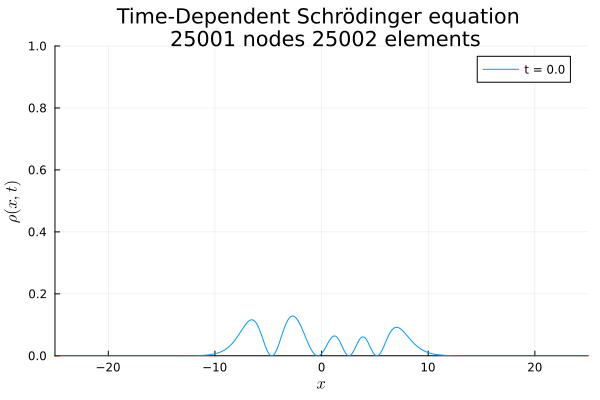

In [19]:
anim‚ÇÅ = @animate for i in 1:length(time_vec)
    œÅ‚Çïreim_1D=real(conj(ùõπ‚Çì‚Çú[i].(pts)).*ùõπ‚Çì‚Çú[i].(pts)) #./ (ùõπ‚Çì‚Çú_norm[i]^2)
    plot(x[:],œÅ‚Çïreim_1D,label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-25,25))
    plot!(title="Time-Dependent Schr√∂dinger equation \n 25001 nodes 25002 elements",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-25,25))
end

gif(anim‚ÇÅ, fps = 10)